<img src = "../../Data/bgsedsc_0.jpg">

# KNN - SVM project

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*icustay_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model.
5. Assess expected accuracy and tune your models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.


# Importing packages, defining functions and global variables

In this section we will import all packages used and we will also define some functions that will be used further in the notebook

In [224]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

from datetime import timedelta
import datetime as datetime

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns

In [225]:
SEED = 10
COLUMNS_TO_DROP = ["DOD","DISCHTIME","DEATHTIME","subject_id", "LOS"]

In [384]:
#functions
def df_separator_dataType(df, dataType):
    """This function allows for the selection of a subsample of a dataFrame
    in terms of dataType columns."""
    features_list = [feat for feat in df.select_dtypes(include = dataType).columns]
    return df[features_list].copy()

def age_from_data(df, birth_column, measure_time_column, diff_column):
    """This function gets a dataframe with birth date, time of measure, and lag in
    all measures columns, and creates the columns age, month, year and hour (of time of measure),
    and a binary variable to describe if the measured time was at night or not. It then deletes 
    the columns introduced as arguments of the dataframe."""
    df = df.copy()
    #transform diff into a datatype that can be operated with datetime objects
    df[diff_column]=df.apply(lambda x: timedelta(days=-int(x[diff_column])),axis=1)
    #transforming date string to datetime object
    df[birth_column] = df.apply(lambda x: datetime.datetime.strptime(x[birth_column],'%Y-%m-%d %H:%M:%S'),axis=1)
    #substracting days of diff from datetime
    df[birth_column] = df.apply(lambda x: (x[birth_column].to_pydatetime() - x[diff_column]),axis=1)
    #transforming date string to datetime object
    df[measure_time_column] = df.apply(lambda x: datetime.datetime.strptime(x[measure_time_column],'%Y-%m-%d %H:%M:%S'),axis=1)
    #substracting days of diff from datetime
    df[measure_time_column] = df.apply(lambda x: (x[measure_time_column].to_pydatetime() - x[diff_column]),axis=1)
    #calculating age
    df['age']=df.apply(lambda x: ((x[measure_time_column].to_pydatetime() - x[birth_column].to_pydatetime()).days)/365,axis=1)
    
    df['month'] = df[measure_time_column].apply(lambda x: x.month)
    df['year'] = df[measure_time_column].apply(lambda x: x.year)
    df['hour'] = df[measure_time_column].apply(lambda x: x.hour)
    #getting a binary column to know if they entered at night
    df['night_entrance']=np.where((df['hour'] > 22) | (df['hour'] < 6) , 1, 0)
    #deleting original columns
    df = df.drop([birth_column, measure_time_column, diff_column], axis = 1)

    return df

def reweight(pi,q1=0.5,r1=0.5):
    """This function is used for reweighting the probabilities in the SVM
    prediction"""
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

## Data preparation

#### Data loading

In [227]:
data=pd.read_csv('Data/mimic_train.csv')
data_test=pd.read_csv('Data/mimic_test_death.csv')

We will need to drop columns that we don't know on the first day of a patient in an ICU or are unnecessary ids

In [228]:
for column in COLUMNS_TO_DROP:
    try:
        data = data.drop(column, axis = 1)
        data_test = data_test.drop(column, axis = 1)
    except:
        continue

In [229]:
print(data.columns)
print(len(data.columns))
print(data_test.columns)
print(len(data_test.columns))

Index(['HOSPITAL_EXPIRE_FLAG', 'hadm_id', 'icustay_id', 'HeartRate_Min',
       'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min',
       'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean',
       'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT'],
      dtype='object')
39
Index(['hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 

The only different column between data and data_test is HOSPITAL_EXPIRE_FLAG, the target feature. Now we can analyze the quantity of nan values for each dataset:

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   hadm_id               20885 non-null  int64  
 2   icustay_id            20885 non-null  int64  
 3   HeartRate_Min         18698 non-null  float64
 4   HeartRate_Max         18698 non-null  float64
 5   HeartRate_Mean        18698 non-null  float64
 6   SysBP_Min             18677 non-null  float64
 7   SysBP_Max             18677 non-null  float64
 8   SysBP_Mean            18677 non-null  float64
 9   DiasBP_Min            18676 non-null  float64
 10  DiasBP_Max            18676 non-null  float64
 11  DiasBP_Mean           18676 non-null  float64
 12  MeanBP_Min            18699 non-null  float64
 13  MeanBP_Max            18699 non-null  float64
 14  MeanBP_Mean           18699 non-null  float64
 15  RespRate_Min       

In [231]:
data.isna().sum()[:10]

HOSPITAL_EXPIRE_FLAG       0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
dtype: int64

In [232]:
data_test.isna().sum()[:10]

hadm_id             0
icustay_id          0
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
dtype: int64

We see that there are approximatelly 10% of the data with NaN values, so it is interesting to find a way of imputing them. At the same time, the test set also has NaN values, and we cannot drop any column there. Which makes imputing even more important.

### Formating dates features

As there is some interesting information (as age for example) contained in all date related columns, we need to process them

In [233]:
#processing time data to calculate age
data = age_from_data(data, "DOB", "ADMITTIME", "Diff")
data_test = age_from_data(data_test, "DOB", "ADMITTIME", "Diff")

In [234]:
#we will substitute values with an age higher than 100 years with a NaN to latter impute it with an imputer
data.loc[data["age"]>100,"age"] = np.nan
data_test.loc[data_test["age"]>100,"age"] = np.nan

In [235]:
#checking it has worked fine
print(data["age"].isna().sum())
print(data_test["age"].isna().sum())

1107
270


### Adding comorbidities

We will also add information about the comorbidities, as this can give some interesting infromation for inference. It makes sense to think that the more number of comorbidities a pacient has when it enters the ICU, the less probabilities of surviving he or she has. 

In [236]:
data_extra = pd.read_csv("Data/extra_data/MIMIC_diagnoses.csv")
data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SUBJECT_ID  651047 non-null  int64  
 1   HADM_ID     651047 non-null  int64  
 2   SEQ_NUM     651000 non-null  float64
 3   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.9+ MB


In [237]:
#building a df with icustay_id, and number of comorbidities. This df has a row for each comorbidity, 
#so if we count all the rows per icustay_id we should get the number of comorbidities per icustay_id
# be aware that this df has a lot more icustay_id than the training dataset, so we cannot inner merge
comorbidities_num = data_extra["HADM_ID"].value_counts()
comorbidities_num


141249    39
194067    39
115833    39
177317    39
173748    39
          ..
126552     1
179808     1
151596     1
148607     1
173719     1
Name: HADM_ID, Length: 58976, dtype: int64

In [238]:
data = pd.merge(data, comorbidities_num, left_on="hadm_id", right_index=True, how="left")
data_test = pd.merge(data_test, comorbidities_num, left_on="hadm_id", right_index=True, how="left")

In [239]:
data = data.rename(columns={'HADM_ID': 'comorbidity_counts'})
data = data.drop("hadm_id", axis = 1)

data_test = data_test.rename(columns={'HADM_ID': 'comorbidity_counts'})
data_test = data_test.drop("hadm_id", axis = 1)

## Preprocessing

In [240]:
# First we separate datasets into numerical and categorical data
data_train_num = df_separator_dataType(data, np.number)
data_train_cat = df_separator_dataType(data, object)
data_train_cat["icustay_id"] = data_train_num["icustay_id"]

data_test_num = df_separator_dataType(data_test, np.number)
data_test_cat = df_separator_dataType(data_test, object)
data_test_cat["icustay_id"] = data_test_num["icustay_id"]

## Numerical processing

### Feature importance

The first interesting think we can do is analyze which columns have less correlation with the target. We can delete those columns that we consider do not add any information, as they can be more harmful than helpful. A threshold of 5% correlation will be used to determine which columns to get rid of.

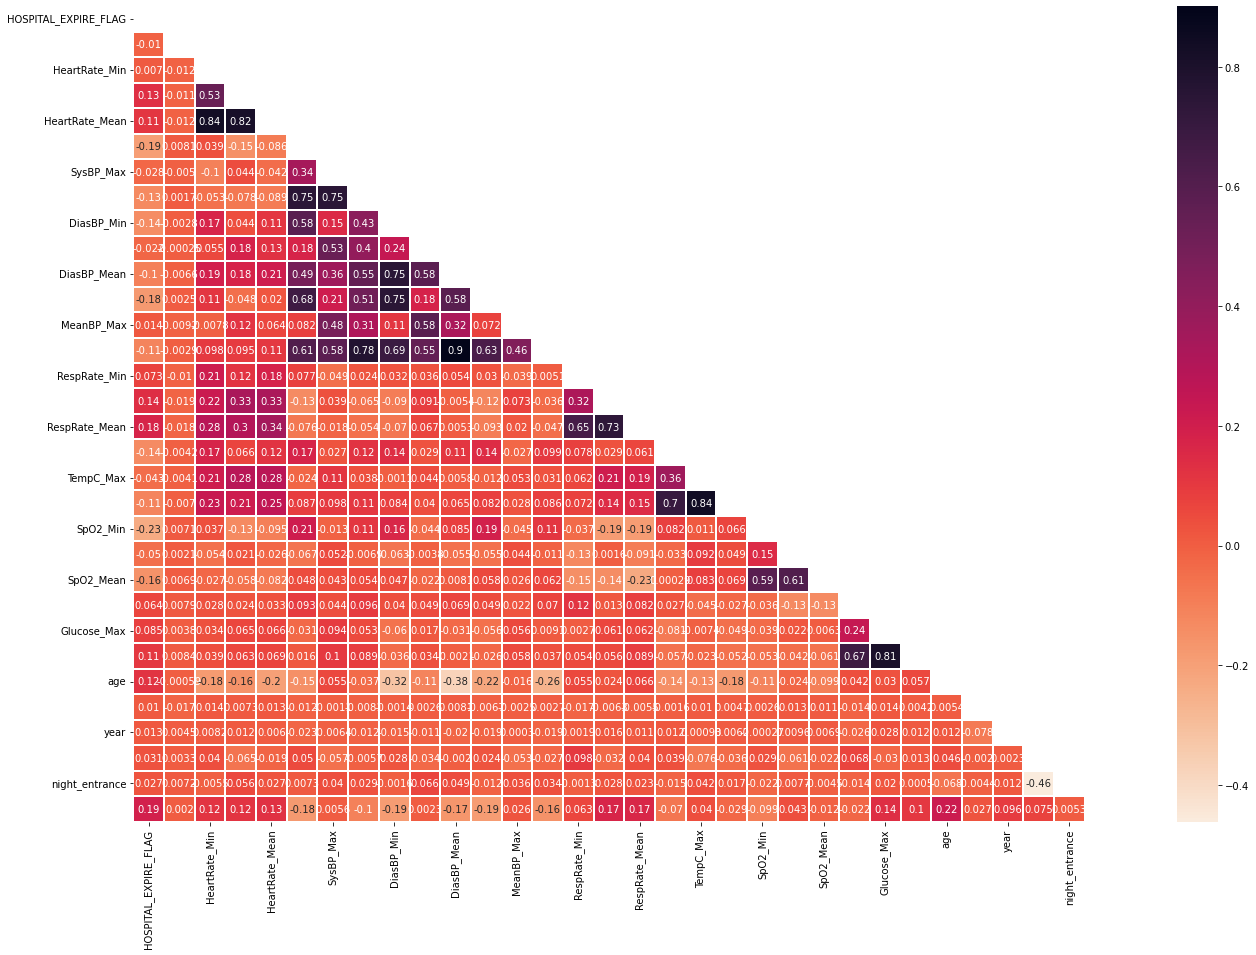

In [241]:
from matplotlib import pyplot as plt
sns.heatmap(data_train_num.corr(), linewidths=0.1, square=False, cmap=sns.color_palette("rocket_r", as_cmap=True), linecolor='white', annot=True,
            mask= np.triu(np.ones_like(data_train_num.corr(), dtype=np.bool_)))

fig = plt.gcf()
fig.set_size_inches(22, 15)



In [242]:
list_of_uncorrelated_features = list((abs(data_train_num.corr().loc[abs(data_train_num.corr()["HOSPITAL_EXPIRE_FLAG"])<0.05,"HOSPITAL_EXPIRE_FLAG"])).index)

data_train_num = data_train_num.drop([feat for feat in list_of_uncorrelated_features if feat != "icustay_id"], axis = 1)
data_test_num = data_test_num.drop([feat for feat in list_of_uncorrelated_features if feat != "icustay_id"], axis = 1)

In [243]:
data_train_num.head()

,HOSPITAL_EXPIRE_FLAG,icustay_id,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Mean,DiasBP_Min,DiasBP_Mean,MeanBP_Min,MeanBP_Mean,...,RespRate_Mean,TempC_Min,TempC_Mean,SpO2_Min,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age,comorbidity_counts
0,0,228357,145.0,121.043478,74.0,106.586957,42.0,61.173913,59.0,74.543478,...,22.347826,35.111111,36.080247,90.0,95.739130,111.0,230.0,160.777778,69.608219,17
1,0,221004,110.0,79.117647,89.0,106.733333,49.0,64.733333,58.0,74.800000,...,16.058824,36.333333,36.472222,98.0,99.058824,103.0,103.0,103.000000,42.101370,3
2,0,296315,98.0,91.689655,88.0,112.785714,45.0,56.821429,64.0,72.888889,...,15.900000,36.444444,36.666667,100.0,100.000000,132.0,346.0,217.636364,68.210959,14
3,0,245557,128.0,98.857143,84.0,106.972973,30.0,41.864865,48.0,62.783784,...,26.771429,36.333333,37.833333,78.0,95.085714,108.0,139.0,125.000000,74.961644,15
4,0,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,79.424658,16


### Missing values

Now we can process the missing values. What will be more restrictive will be the testing data. If we find that there are only some columns with NaNs in testing, we could think of dropping them. But as we will see, there are too many columns containing NaNs, which will force us to impute values if we want to make use of all the information available.

In [244]:
#processing missing data. As we have missing data 
#counting number of columns with nans in test dataset
(data_test_num.isna().sum() > 0).sum()

19

we can see that test data has almost all columns with nans, so we cannot drop that many columns. We need to impute the values. We will use KNN imputer with 1000 neighbors and distance as the weight.

In [320]:

y = data_train_num["HOSPITAL_EXPIRE_FLAG"]
X_num = data_train_num.drop("HOSPITAL_EXPIRE_FLAG", axis = 1)

Now, to avoid ids creating problems when imputing, we need to separate them from the dataset

In [246]:
#Separating ids
train_ids = X_num["icustay_id"].copy()
X_train_num = X_num.copy().drop("icustay_id",axis = 1)
test_ids = data_test_num["icustay_id"].copy()
X_test_num = data_test_num.drop("icustay_id",axis = 1)

In [247]:
#we create and fit the iterative imputer
imputer_num = KNNImputer(n_neighbors=1000, 
                    weights='distance')
                    #add_indicator=False) maybe is interesting for future iterations

imputer_num.fit(X_train_num)
X_train_imp = imputer_num.transform(X_train_num)
X_test_imp = imputer_num.transform(X_test_num)

In [248]:
#checking if train set has nans
pd.DataFrame(data = X_train_imp, columns = X_train_num.columns).isna().sum().sum()

0

In [249]:
#checking if test set has nans
pd.DataFrame(data = X_test_imp, columns = X_test_num.columns).isna().sum().sum()

0

### Standardizing

The final step for the numerical data is to standardize it. We will use RobustScaler, that is robust to ouliers

In [250]:
#creating scaler and scaling the data
scaler = RobustScaler()
scaler.fit(X_test_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns=X_train_num.columns)
X_train_scaled["icustay_id"] = train_ids

X_test_scaled = scaler.transform(X_test_imp)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns= X_test_num.columns)
X_test_scaled["icustay_id"] = test_ids

## Categorical processing

In [251]:
data_train_cat.head()

,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,icustay_id
0,F,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,228357
1,F,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,221004
2,F,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,296315
3,F,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,245557
4,F,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,225281


### Dealing with sparse categorical variables

As we can see, from all the categorical variables, DIAGNOSIS and ICD9_diagnosis are VERY sparse. We could also include ethnicity in this group. We need to find a way to encode them as categoricals that does not focus on one hot encoding technique. We will use target encoding, which allows us to encode each class inside each variable in terms of the probability of dying. We will use WoE(weight of evidence) encoder in particular.

In [252]:
data_train_cat.nunique()

GENDER                2
ADMISSION_TYPE        3
INSURANCE             5
RELIGION             17
MARITAL_STATUS        7
ETHNICITY            41
DIAGNOSIS          6193
ICD9_diagnosis     1853
FIRST_CAREUNIT        5
icustay_id        20885
dtype: int64

In [256]:
#We could target encode, but I have found a method (WoE) that follows the same approach but with a different approximation.
woe_encode_columns = ["DIAGNOSIS","ICD9_diagnosis", "ETHNICITY"]

woe = ce.woe.WOEEncoder(cols = woe_encode_columns)

# Fit
woe.fit(data_train_cat, y)

# Transform
encoded_train_cat = woe.transform(data_train_cat)
encoded_test_cat = woe.transform(data_test_cat)


The other variables will be one hot encoded, as they do not add to many dimensions to the dataset. But only GENDER, ADMISSION_TYPE, FIRST_CAREUNIT will be encoded. INSURANCE, RELIGION, MARITAL_STATUS will be dropped as it has been considered that they do not add any information regarding the target to predict

In [257]:
from category_encoders.one_hot import OneHotEncoder
#we are not going to one hot encode all vars. The ones not one hot encoded will be dropped
one_hot_encode_vars = ["GENDER", "ADMISSION_TYPE", "FIRST_CAREUNIT"]
drop_columns = ["INSURANCE", "RELIGION", "MARITAL_STATUS"]
OneHotEncoder = OneHotEncoder(cols=one_hot_encode_vars, 
              handle_missing='value', 
              handle_unknown='value')

OneHotEncoder.fit(encoded_train_cat)

encoded_train_cat = OneHotEncoder.transform(encoded_train_cat)
encoded_train_cat = encoded_train_cat.drop(drop_columns, axis = 1)

encoded_test_cat = OneHotEncoder.transform(encoded_test_cat)
encoded_test_cat = encoded_test_cat.drop(drop_columns, axis = 1)

In [258]:
encoded_train_cat

,GENDER_1,GENDER_2,ADMISSION_TYPE_1,ADMISSION_TYPE_2,ADMISSION_TYPE_3,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT_1,FIRST_CAREUNIT_2,FIRST_CAREUNIT_3,FIRST_CAREUNIT_4,FIRST_CAREUNIT_5,icustay_id
0,1,0,1,0,0,-0.021504,-0.434535,-0.113517,1,0,0,0,0,228357
1,1,0,1,0,0,-0.021504,0.968288,0.000000,1,0,0,0,0,221004
2,1,0,1,0,0,-0.216931,-0.229785,0.888246,1,0,0,0,0,296315
3,1,0,0,1,0,-0.021504,0.457463,-0.572157,0,1,0,0,0,245557
4,1,0,1,0,0,-0.021504,0.321661,-1.131773,0,0,1,0,0,225281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,1,1,0,0,-0.021504,0.123500,0.680606,1,0,0,0,0,244530
20881,0,1,1,0,0,-0.360848,-0.330995,-0.498049,0,1,0,0,0,216116
20882,1,0,1,0,0,-0.216931,-0.073166,0.000000,1,0,0,0,0,274507
20883,1,0,1,0,0,-0.021504,0.000000,-2.528219,0,0,0,0,1,225930


### Putting everything together, over-sampling

Finally, we will merge both datasets (categorical and numerical) into a final one. Then, only for KNN, we will over-sample positive cases, as they are only the 10% of the dataset.

In [321]:
#Put everything together
data_train_final = pd.merge(encoded_train_cat, X_train_scaled, right_on = "icustay_id", left_on="icustay_id", validate="one_to_one")
data_train_final = data_train_final.drop("icustay_id", axis = 1)

data_test_final = pd.merge(encoded_test_cat, X_test_scaled, right_on = "icustay_id", left_on="icustay_id", validate="one_to_one")
data_test_final = data_test_final.drop("icustay_id", axis = 1)

In [260]:
#code to find all categorical columns in the final datasets
columns = data_train_final.columns
cat_columns = one_hot_encode_vars

indices_cat = np.zeros(len(columns))

for column in cat_columns:
    print(column)
    for i in range(len(columns)):
        if column in columns[i]:
            indices_cat[i] += 1

indices_cat = indices_cat != 0
columns[indices_cat]


GENDER
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
ADMISSION_TYPE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
FIRST_CAREUNIT
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


Index(['GENDER_1', 'GENDER_2', 'ADMISSION_TYPE_1', 'ADMISSION_TYPE_2',
       'ADMISSION_TYPE_3', 'FIRST_CAREUNIT_1', 'FIRST_CAREUNIT_2',
       'FIRST_CAREUNIT_3', 'FIRST_CAREUNIT_4', 'FIRST_CAREUNIT_5'],
      dtype='object')

In [278]:
#we oversample to compensate the imbalanced data
from imblearn.over_sampling import SMOTENC
sampler = SMOTENC(categorical_features=indices_cat, random_state=SEED)
X_res, y_res = sampler.fit_resample(data_train_final, y)

## KNN training

Finally we train the model

In [281]:
#creating and fitting the model with grid search to optimize hyperparameters
"""param_dist = {
    "n_neighbors": [155,160,165,170],
    "weights": ["uniform", "distance"],
}"""
param_dist = {
    "n_neighbors": [5,10,15,20],
    "weights": ["uniform", "distance"],
}
model = KNeighborsClassifier(algorithm='brute',metric='minkowski', n_jobs=3)

cv = GridSearchCV(model, param_dist, scoring="roc_auc", n_jobs=1, cv=2, verbose=2, return_train_score=True)
cv.fit(X_res, y_res)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.7s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.7s
[CV] END ....................n_neighbors=5, weights=distance; total time=   0.7s
[CV] END ....................n_neighbors=5, weights=distance; total time=   0.7s
[CV] END ....................n_neighbors=10, weights=uniform; total time=   0.6s
[CV] END ....................n_neighbors=10, weights=uniform; total time=   0.6s
[CV] END ...................n_neighbors=10, weights=distance; total time=   0.7s
[CV] END ...................n_neighbors=10, weights=distance; total time=   0.6s
[CV] END ....................n_neighbors=15, weights=uniform; total time=   0.6s
[CV] END ....................n_neighbors=15, weights=uniform; total time=   0.7s
[CV] END ...................n_neighbors=15, weights=distance; total time=   0.7s
[CV] END ...................n_neighbors=15, weigh

GridSearchCV(cv=2, estimator=KNeighborsClassifier(algorithm='brute', n_jobs=3),
             n_jobs=1,
             param_grid={'n_neighbors': [5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [282]:
print(cv.best_params_)
print(cv.best_score_)

{'n_neighbors': 10, 'weights': 'distance'}
0.9682867097467909


In [274]:
y_pred = cv.predict_proba(data_test_final)


5221.0

In [275]:
#ensuring the y_pred is correct. It needs to output the size of the testing dataset
print(y_pred.sum().sum())
print(len(y_pred))

5221

In [283]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_pred[:, 1]})
test_predictions_submit.to_csv("test_predictions_submit_KNN.csv", index = False)

# SVM section

### Dimensionality reduction

As SVM can be very expensive to train, it is interesting to analyze the possibility of dimensionality reduction to compress as much as possible the dataset. For this reason we will implement IncrementalPCA. We will also get a sample of the dataset to speed up the hyper parameter tunning phase. We will get a 20% of the data, which will be enough to get a good estimation of the parameters.

In [329]:
#randomly selecting a subsample of the data to optimize hyperparameters
data_train_final_svm = data_train_final.copy()
y_svm = y.copy()
data_train_final_svm["target"] = y_svm.copy()
data_train_final_svm = data_train_final_svm.sample(n = 4000)

y_svm = data_train_final_svm["target"]
data_train_final_svm = data_train_final_svm.drop("target", axis = 1)

We apply dimensionality reduction to speed up SVM training

In [330]:
from sklearn.decomposition import IncrementalPCA

PCA = IncrementalPCA()
PCA.fit(data_train_final_svm)
reduced_data_train_final_svm = PCA.transform(data_train_final_svm)
reduced_data_test_final = PCA.transform(data_test_final)

In [331]:
reduced_data_train_final_svm.shape

(4000, 33)

In [332]:
data_train_final_svm.shape

(4000, 33)

We observe that there is no dimensionality reduction, meaning that the data cannot be further compressed without lossing information

### Model training

Now we train the model with GridSearchCV to obtain the best hyper parameters combination using the sample of the dataset. We will use the argument class_weight='balanced' to ensure that the model takes into account class imbalance.

In [362]:
#creating and fitting the model with grid search to optimize hyperparameters
#the cv is small to have a fast training for this implementation

"""First iterations of parameters:
param_dist = {  'C':[0.05,0.08,0.1,0.2], 
                'gamma':[0.05,0.1,0.2], 
                'kernel':['linear', 'rbf']}

SECOND ITERATION
param_dist = {
    "C": [0.4,0.5,0.6],
    "kernel": ["linear", "rbf"],
    "gamma": [0.05,0.01,0.02]
}
...
"""
param_dist = {  'C':[0.4,0.5,0.6], 
                'gamma':[0.005,0.01,0.02], 
                'kernel':["linear",'rbf']}
#we add the class_weight argument to deal with class imbalance. Only 10% of the observations are positive.
model = SVC(class_weight='balanced',probability=True,random_state=SEED)

cv = GridSearchCV(model, param_dist, scoring="roc_auc", n_jobs=3, cv=2, verbose=2, return_train_score=True)
cv.fit(reduced_data_train_final_svm, y_svm)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.4, gamma=0.005, kernel=linear; total time=   1.0s
[CV] END ..................C=0.4, gamma=0.005, kernel=linear; total time=   1.0s
[CV] END ...................C=0.4, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END .....................C=0.4, gamma=0.005, kernel=rbf; total time=   2.1s
[CV] END ...................C=0.4, gamma=0.01, kernel=linear; total time=   0.8s
[CV] END .....................C=0.4, gamma=0.005, kernel=rbf; total time=   1.8s
[CV] END ...................C=0.4, gamma=0.02, kernel=linear; total time=   0.9s
[CV] END ......................C=0.4, gamma=0.01, kernel=rbf; total time=   1.6s
[CV] END ......................C=0.4, gamma=0.01, kernel=rbf; total time=   1.6s
[CV] END ...................C=0.4, gamma=0.02, kernel=linear; total time=   0.9s
[CV] END ..................C=0.5, gamma=0.005, kernel=linear; total time=   0.9s
[CV] END ......................C=0.4, gamma=0.02

GridSearchCV(cv=2,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=10),
             n_jobs=3,
             param_grid={'C': [0.4, 0.5, 0.6], 'gamma': [0.005, 0.01, 0.02],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='roc_auc', verbose=2)

Here we can see the best hyper parameters combination

In [364]:
print(cv.best_params_)
print(cv.best_score_)

{'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}
0.8739805093799812


Now we need to reweight the probabilities because we have done modifications for class imbalance

/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


<AxesSubplot:title={'center':'prob'}, xlabel='y'>

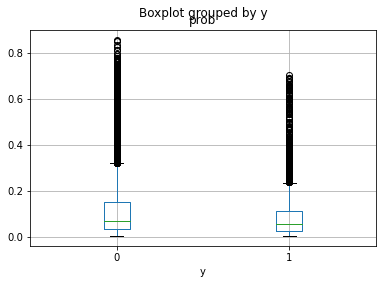

In [383]:
reweighted_outsample_pred_res = pd.DataFrame({'y': y, 'prob': pd.Series(cv.predict_proba(data_train_final)[:,1])})
reweighted_outsample_pred_res.boxplot(column="prob",by="y")

/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


<AxesSubplot:title={'center':'prob'}, xlabel='y'>

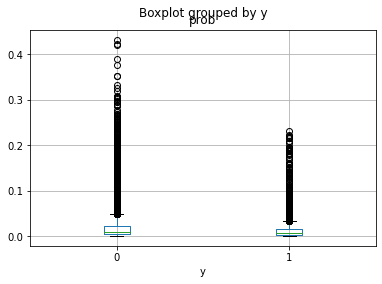

In [378]:
q1 = y.sum()/len(y)
r1 = 0.5


reweighted_outsample_pred_res = pd.DataFrame({'y': y, 'prob': pd.Series(cv.predict_proba(data_train_final)[:,1]).apply(reweight,args=(q1,r1))})
reweighted_outsample_pred_res.boxplot(column="prob",by="y")

And now we can train the whole model with those hyper parameters to ensure the model learns all the information the data can give

In [370]:
best_SVM_model = model.set_params(**cv.best_params_)
best_SVM_model.fit(data_train_final, y)

SVC(C=0.5, class_weight='balanced', gamma=0.01, probability=True,
    random_state=10)

<AxesSubplot:title={'center':'prob'}, xlabel='y'>

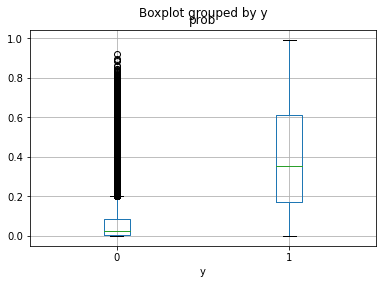

In [ ]:
reweighted_outsample_pred_res = pd.DataFrame({'y': y, 'prob': pd.Series(best_SVM_model.predict_proba(data_train_final)[:,1])})
reweighted_outsample_pred_res.boxplot(column="prob",by="y")

<AxesSubplot:title={'center':'prob'}, xlabel='y'>

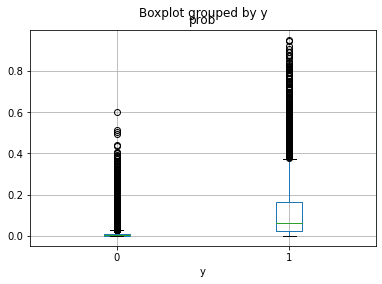

In [ ]:
q1 = y.sum()/len(y)
r1 = 0.5


reweighted_outsample_pred_res = pd.DataFrame({'y': y, 'prob': pd.Series(best_SVM_model.predict_proba(data_train_final)[:,1]).apply(reweight,args=(q1,r1))})
reweighted_outsample_pred_res.boxplot(column="prob",by="y")

In [371]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y,best_SVM_model.predict(data_train_final))

0.8178952670765451

### Output creation

In [ ]:
reweighted_outsample_pred_res_test = pd.Series(best_SVM_model.predict_proba(data_test_final)[:,1]).apply(reweight,args=(q1,r1))

In [397]:
reweighted_outsample_pred_res_test_cv = pd.Series(cv.predict_proba(data_test_final)[:,1]).apply(reweight,args=(q1,r1))

/Users/javier/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [399]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": reweighted_outsample_pred_res_test_cv})
test_predictions_submit.to_csv("test_predictions_submit_svm.csv", index = False)